### Step 1 - Load Data

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import glob
#import skvideo.io
import os

In [3]:
img = cv2.imread('data/images/image-0000001.jpg')
plt.imshow(img)
plt.show()

TypeError: Image data can not convert to float

In [4]:
def opt_flow(frame1,frame2):
    #hsv = np.zeros_like(frame1)
    #hsv[...,1] = 255
    gray1 = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(gray1,gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    ang = ang*180/np.pi/2
    
    ret = np.array([mag,ang])
    ret = np.swapaxes(ret,0,2)
    ret = np.swapaxes(ret,0,1)
    #print(ret.shape)
    return ret

#rgb = opt_flow(frame1,frame2)
#plt.imshow(rgb)

### Step 2: Data Augmentation

In [5]:
def rotate(img,angle):
    rows, cols, layers = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(img,M,(cols,rows))

def flip(img):
    return cv2.flip(img,1)

def crop(img,maxh,minh):
    copy = img[:,:,:]
    return copy[minh:maxh,:]

def resize(img,w,h):
    resized_image = cv2.resize(img, (w, h))
    return resized_image

read_dir = "data/images/image-"
write_dir = "data/processed/image-"
filetype = ".jpg"

num_digits = '07'

90 160


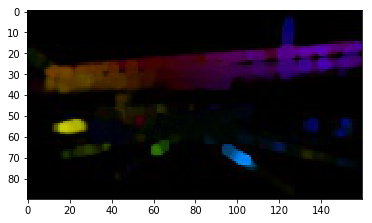

In [8]:
img = cv2.imread('data/processed/image-0000002.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
rows, cols , layers = img.shape
print(rows,cols)
plt.imshow(img)
plt.show()

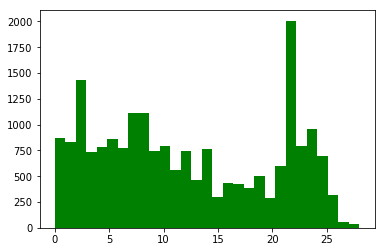

Length of return value: 13611
Chopped Train Classes


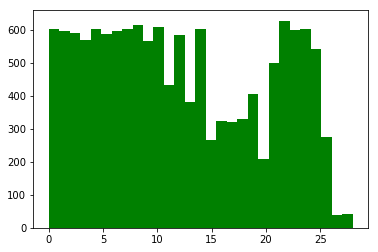

Equalized Train Classes


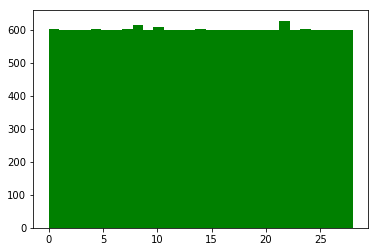

Validation Set Classes


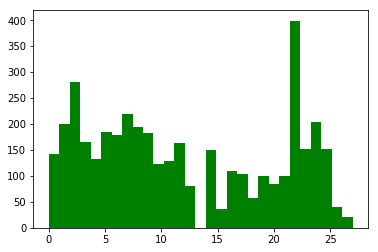

In [44]:
import sklearn

def get_img_num(filename):
    return int(str(filename).split('-')[1].split('.')[0])

def count_chart(files,speeds):
    count = [round(speeds[get_img_num(file)]) for file in files]
    plt.hist(count, 29, facecolor='g', alpha=1)
    plt.show()
    
def get_image_names(num_images):
    return ["data/train/image-"+format(i,num_digits)+".npy" for i in range(1,num_images+1)]
    
    
def get_speeds(file):
    return list(map(float,open(file).read().splitlines()))


def filter_images(files,speeds,threshold = 600):
    bincount = get_bincount(files,speeds)
    ret = []
    for file in files:
        img_num = get_img_num(file)
        speed = round(speeds[img_num])
        rand = np.random.rand()
        if threshold/(bincount[speed]*1.0) > rand:
            #print(threshold/(bincount[speed]*1.0),speed,rand)
            ret.append(file)
    
    print("Length of return value:",len(ret))
    return ret

def duplicate_images(files,speeds,threshold = 600):
    
    
    bincount = get_bincount(files,speeds)
    
    while min(bincount) < threshold :
        files = sklearn.utils.shuffle(files)
        for file in files:
            img_num = get_img_num(file)
            speed = round(speeds[img_num])
            if bincount[speed] < threshold:
                files.append(file)
                bincount[speed] += 1
                
    return files
                
                

def get_bincount(files,speeds):
    return np.bincount([round(speeds[get_img_num(file)]) for file in files])

def non_shuffling_train_test_split(X, test_size=0.2):
    i = int(test_size * len(X)) + 1
    X_test, X_train = np.split(X, [i])
    return X_train, X_test
        
def custom_train_test_split(X,test_size = 0.2):
    X_train = []
    X_test = []
    for i in range(len(X)):
        if i % 100 > 79:
            X_test.append(X[i])
        else:
            X_train.append(X[i])
            
    return X_train,X_test


#Load Data and get count
images = get_image_names(20399)
speeds = get_speeds("data/train.txt")
count_chart(images,speeds)

#Filter images
train_data, validation_data = custom_train_test_split(images, test_size = 0.2)

train_data = filter_images(train_data,speeds,600)
print("Chopped Train Classes")
count_chart(train_data,speeds)

train_data = duplicate_images(train_data,speeds,600)
print("Equalized Train Classes")
count_chart(train_data,speeds)

print("Validation Set Classes")
count_chart(validation_data,speeds)


Opt Flow Test

In [11]:
im1 = cv2.imread('data/images/image-0004081.jpg')
im2 = cv2.imread('data/images/image-0004082.jpg')

#print(cv2.resize(crop(opt_flow(im1,im2),360,0),(160,90)).shape)
#img = cv2.resize(crop(opt_flow(im1,im2),360,0),(160,90))
#print(img.shape)

#print(opt_flow(im1,im2)[0][0][0])
#print(opt_flow(im1,im2)[0][0][1])
#print(opt_flow(im1,im2).shape)
#print(img[0][0][0])
#print(img[0][0][1])
#print(img.shape)

In [ ]:

num_digits = '07'
prev = cv2.imread("data/images/image-"+format(1,num_digits)+".jpg")
for i in range(2,20401):
    cur = cv2.imread("data/images/image-"+format(i,num_digits)+".jpg")
    img = cv2.resize(crop(opt_flow(prev,cur),360,0),(160,90))
    np.save("data/train/image-"+format(i-1,num_digits),img)
    
    prev = cur
    
    if i % 100 == 0:
        print(i)
    

### Step 3: Generator

In [25]:

max1,max2,min1,min2 =  float('-inf'), float('-inf'), float('inf'), float('inf')

ranges = [[float('-inf'),float('inf')],[float('-inf'),float('inf')]]
for image in images:
    im1 = np.load(image)
    for i in range(2):
        ranges[i][0] = max(ranges[i][0],np.max(im1[:,:,i]))
        ranges[i][1] = min(ranges[i][1],np.min(im1[:,:,i]))

        
    
print(ranges)

KeyboardInterrupt: 

In [52]:
num_aug = 4
from imgaug import augmenters as iaa

def generator(speed_list,image_names_gen, batch_size=32*num_aug):
    
    angles = np.arange(-1,2,1)
    # Best - 0.05,0.1 -- 0.1,0.02
    coarse = iaa.CoarseDropout(p=(0.05,0.1), size_percent=(0.1,0.02))
    while 1: # Loop forever so the generator never terminates
        #print("test1")
        image_names_gen = sklearn.utils.shuffle(image_names_gen)
        # batch_size/10 because for each row we add 10 images
        for offset in range(0, len(image_names_gen), int(batch_size/num_aug)):
            #print("test2")
            batch_lines = image_names_gen[offset:offset+int(batch_size/num_aug)]
                        
            images = []
            speeds = []
            #print("New Batch ---")
            for batch_line in batch_lines:
                
                img_num = get_img_num(batch_line)
                im1 = np.load(batch_line)
                im1[:,:,1] = np.sin(im1[:,:,1]*2*np.pi/180)
                #im1[np.where(im1[:,:,0]>0.1)]=[0,0]

                
                fim1 = flip(im1)
                
                images.append(im1)
                images.append(fim1)
                speeds.append(speed_list[img_num-1])
                speeds.append(speed_list[img_num-1])
                
                for i in range(int((num_aug-2)/2)):
                    images.append(coarse.augment_image(im1))
                    images.append(coarse.augment_image(fim1))
                    speeds.append(speed_list[img_num-1])
                    speeds.append(speed_list[img_num-1])
                
                
                #f1 = cv2.resize(crop(cv2.imread("data/images/image-"+format(img_num-1,num_digits)+".jpg"),360,0),(160,90))
                #f2 = cv2.resize(crop(cv2.imread("data/images/image-"+format(img_num  ,num_digits)+".jpg"),360,0),(160,90))
                
                #cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB)
                #ff1 = flip(f1)
                #ff2 = flip(f2)
                

                #print(img_num)
                #print(img_num)
                #img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                
                #img = cv2.resize(crop(opt_flow(im1,im2),360,0),(160,90))

                #plt.imshow(img)
                #plt.show()
                #flipped = flip(im1)
                
                #print(len(images))
                #images.append(flipped)
                
                #speeds.append(speed_list[img_num-1])
                #for angle in angles:
                #    rf1 = rotate(f1,angle)
                #    rf2 = rotate(f2,angle)
                #    rff1 = rotate(ff1,angle)
                #    rff2 = rotate(ff2,angle)
                #    
                #    images.append(opt_flow(rf1,rf2))
                #    images.append(opt_flow(rff1,rff2))
                #    
                #    speeds.append(speed_list[img_num-1])
                #    speeds.append(speed_list[img_num-1])  
                      
                    
            X_train = np.array(images)/[166.5,1]
            y_train = np.array(speeds)
            yield sklearn.utils.shuffle(X_train, y_train)

            
def valid_gen(speed_list,image_names_valid, batch_size=64):
    
    while 1:
        for offset in range(0, len(image_names_valid), int(batch_size)):
            batch_lines = image_names_valid[offset:offset+int(batch_size)]
            
            images = []
            speeds = []
            
            for batch_line in batch_lines:
                img_num = get_img_num(batch_line)
                #img = cv2.resize(crop(cv2.cvtColor(cv2.imread(batch_line),cv2.COLOR_BGR2RGB),360,0),(160,90))
                im1 = np.load(batch_line)/[166.5,1]
                im1[:,:,1] = np.sin(im1[:,:,1]*2*np.pi/180)
                #im1[np.where(im1[:,:,0]>0.1)]=[0,0]

                images.append(im1)
                speeds.append(speed_list[img_num-1])
            
            X_valid = np.array(images)
            y_valid = np.array(speeds)
            yield sklearn.utils.shuffle(X_valid, y_valid)
            
            
    

Good Model

In [53]:


#X_data,y_data = next(train_generator)
#print(X_data.shape,y_data.shape)
#plt.imshow(X_data[0])
#from keras.models import Model
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers import ELU
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras import regularizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from keras.regularizers import WeightRegularizer

train_generator = generator(speeds,train_data)
validation_generator = valid_gen(speeds,validation_data)
input_shape = (90,160,2)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=0, mode='auto'),
    ModelCheckpoint('models/blinder_test.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto'),
]

num_epochs = 10

In [55]:
# Ran this one. Current best model is models/model.h5
import keras
input_shape = (90,160,2)
import keras.backend as K
def selu(x):
    """Scaled Exponential Linear Unit. (Klambauer et al., 2017)
    # Arguments
        x: A tensor or variable to compute the activation function for.
    # References
        - [Self-Normalizing Neural Networks](https://arxiv.org/abs/1706.02515)
    """
    alpha = 1.6732632423543772848170429916717
    scale = 1.0507009873554804934193349852946
    return scale * K.elu(x, alpha)


beta = 0.000
d = 1
model = Sequential()
#model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape))
model.add(Conv2D(16, 8, 8, subsample=(4, 4), border_mode="same",activation=selu,W_regularizer=l2(beta),input_shape=input_shape))
#model.add(ELU())
model.add(Conv2D(32, 5, 5, subsample=(2, 2), border_mode="same",activation=selu,W_regularizer=l2(beta)))
#model.add(ELU())
model.add(Conv2D(64, 5, 5, subsample=(2, 2), border_mode="same",activation=selu,W_regularizer=l2(beta)))
model.add(Flatten())
model.add(Dense(100 , activation=selu,W_regularizer=l2(beta)))
#model.add(Dropout(0.5))
model.add(Dense(50,  activation=selu,W_regularizer=l2(beta)))
model.add(Dense(10, activation=selu,W_regularizer=l2(beta)))
model.add(Dense(1))


model.compile(loss = 'mse', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=num_epochs,callbacks = callbacks,verbose=1)
model.save('models/last_comma.h5')


Epoch 1/10
69832/69832 [==============================] - 69s - loss: 21.0842 - val_loss: 7.3053
Epoch 2/10
69832/69832 [==============================] - 68s - loss: 5.8701 - val_loss: 5.0418
Epoch 3/10
69832/69832 [==============================] - 67s - loss: 3.6110 - val_loss: 4.4462
Epoch 4/10
69832/69832 [==============================] - 67s - loss: 2.7075 - val_loss: 3.5854
Epoch 5/10
69832/69832 [==============================] - 68s - loss: 2.0422 - val_loss: 3.3066
Epoch 6/10
69832/69832 [==============================] - 68s - loss: 1.7258 - val_loss: 3.5172
Epoch 7/10
69832/69832 [==============================] - 67s - loss: 1.4434 - val_loss: 3.1816
Epoch 8/10
69832/69832 [==============================] - 68s - loss: 1.2006 - val_loss: 2.9883
Epoch 9/10
69832/69832 [==============================] - 67s - loss: 1.1126 - val_loss: 3.1865
Epoch 10/10
69832/69832 [==============================] - 67s - loss: 1.0907 - val_loss: 2.4504


##### model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=num_epochs,callbacks = callbacks,verbose=1)

In [85]:
#Bad Model
#Booo
#Don't run it
input_shape = (90,160,2)
model = Sequential()

model.add(Lambda(lambda x: x / 255 - 0.5, input_shape = input_shape))
#model.add(Cropping2D(cropping = ((70,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample = (2,2)))
model.add(Activation('elu'))
model.add(Convolution2D(36,5,5,subsample = (2,2),activation = "selu"))
model.add(Convolution2D(48,5,5,subsample = (2,2),activation = "selu"))
model.add(Convolution2D(64,3,3,activation = "selu"))
model.add(Convolution2D(64,3,3,activation = "selu"))

model.add(Flatten())
model.add(Dense(100 , activation='selu'))
model.add(Dense(50,  activation='selu'))
model.add(Dense(10, activation='selu'))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*num_aug, validation_data = validation_generator, nb_val_samples=len(validation_data),nb_epoch=num_epochs,callbacks = callbacks,verbose=1)
model.save('models/last_nvidia.h5')

Epoch 1/5
32638/32638 [==============================] - 164s - loss: 57.5556 - val_loss: 78.5251
Epoch 2/5
32638/32638 [==============================] - 163s - loss: 37.7984 - val_loss: 41.0892
Epoch 3/5
32638/32638 [==============================] - 163s - loss: 25.0149 - val_loss: 32.0763
Epoch 4/5
18048/32638 [===============>..............] - ETA: 69s - loss: 19.1192 

KeyboardInterrupt: 

In [56]:
from keras.models import load_model
model = load_model("models/blinder_test.h5")

img = cv2.imread('data/processed/image-0020388.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(crop(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),360,0),(160,90))#,interpolation = cv2.INTER_LANCZOS4)
img = img[None,:]
print(img.shape)
print(model.predict(img))

ValueError: Invalid activation function: selu

In [66]:
def mse(expected,output):
    return pow(expected-output,2)

from keras.models import load_model
import keras.activations
keras.activations.selu = selu
x = 4
model = load_model("models/blinder_test.h5", custom_objects={'selu': selu})
total = 0
start = 4082
for i in range(4082,20401):
    im1 = np.load("data/train/image-"+format(i,num_digits)+".npy")
    
    total += mse(speeds[i-1],model.predict(im1[None,:]))
    
    if i%100 == 0:
        print(total/(i-start))
    

[[ 78637.6171875]]
[[ 110699.4375]]
[[ 72520.]]
[[ 55549.30078125]]
[[ 48625.29296875]]
[[ 41090.890625]]
[[ 36912.99609375]]
[[ 34445.23046875]]
[[ 32908.375]]
[[ 35194.60546875]]
[[ 33402.96484375]]
[[ 32871.33984375]]
[[ 33794.54296875]]
[[ 36270.1640625]]
[[ 36040.7578125]]
[[ 37033.10546875]]
[[ 39878.65625]]
[[ 71800.578125]]
[[ 69022.3515625]]
[[ 66776.9921875]]
[[ 64930.60546875]]
[[ 63125.19140625]]
[[ 62288.05859375]]
[[ 61351.78515625]]
[[ 59385.765625]]
[[ 57488.38671875]]
[[ 57363.6796875]]
[[ 56656.328125]]
[[ 55763.5703125]]
[[ 54561.66015625]]
[[ 53506.84765625]]
[[ 52898.6484375]]
[[ 55920.546875]]
[[ 56279.828125]]
[[ 60395.47265625]]
[[ 61900.91015625]]
[[ 74370.390625]]
[[ 80584.8359375]]
[[ 85594.71875]]
[[ 94980.90625]]
[[ 95146.984375]]
[[ 99384.1796875]]
[[ 101483.671875]]
[[ 101352.0390625]]
[[ 100303.9375]]
[[ 100140.8984375]]
[[ 98588.8828125]]
[[ 97229.7421875]]
[[ 96824.8671875]]
[[ 95602.296875]]
[[ 94555.0390625]]
[[ 93632.4921875]]
[[ 93663.7578125]]
[[ 

KeyboardInterrupt: 

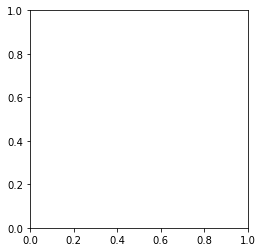

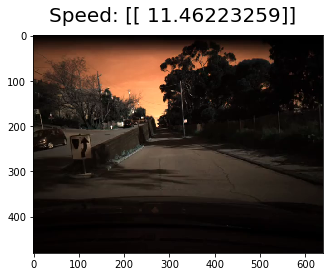

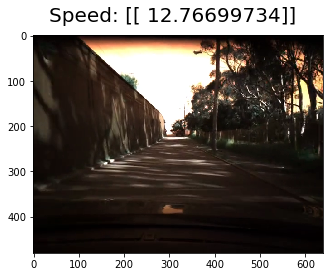

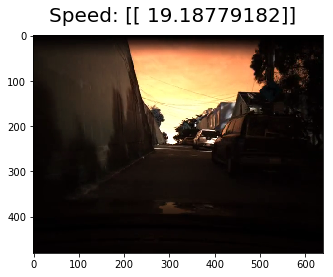

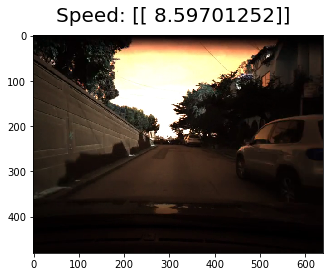

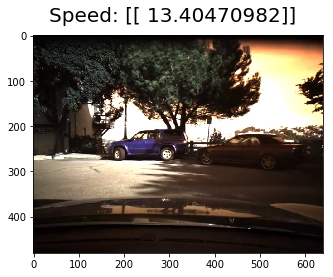

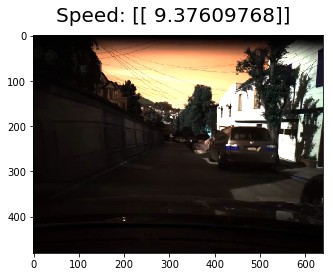

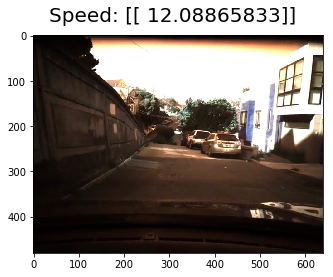

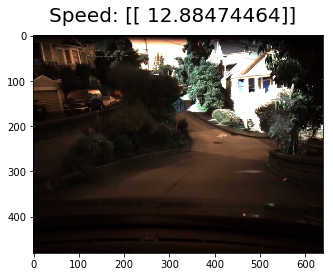

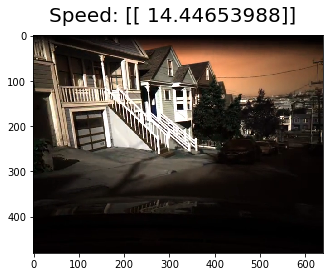

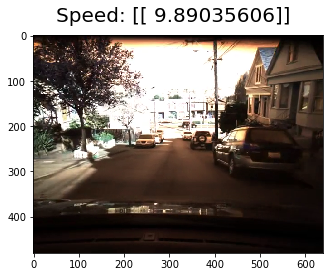

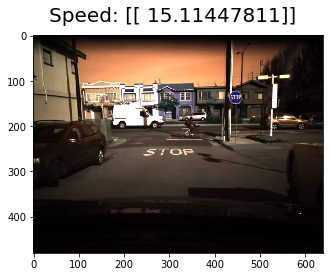

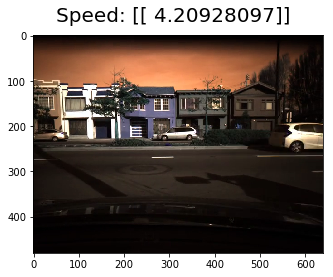

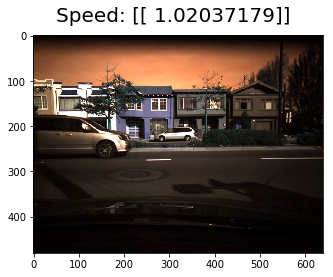

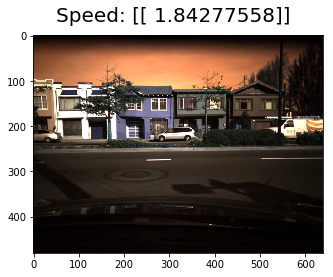

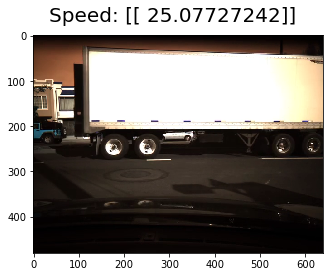

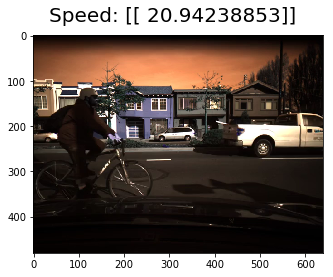

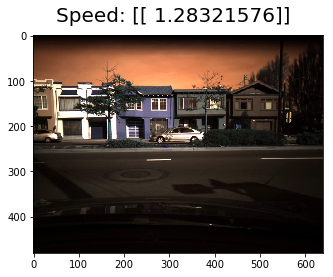

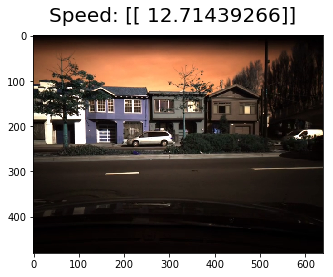

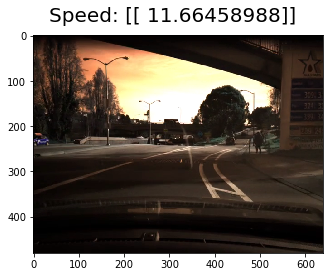

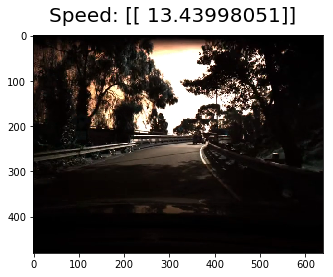

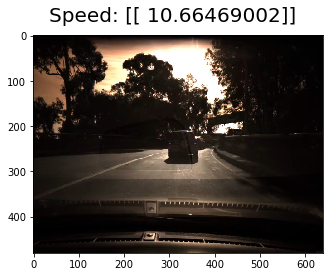

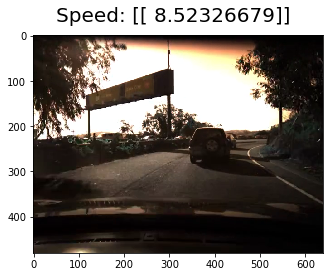

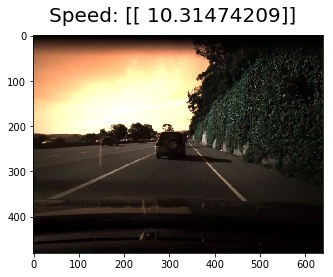

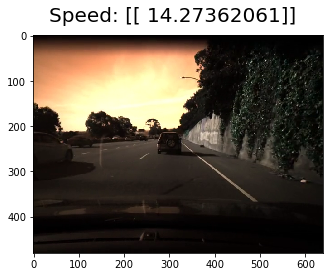

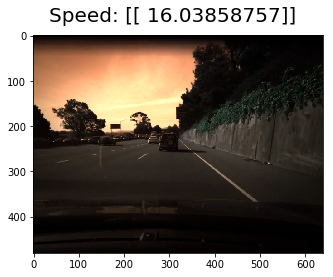

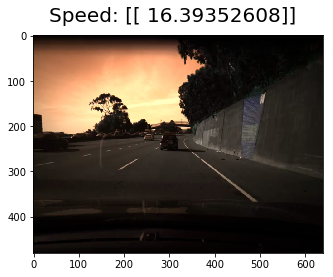

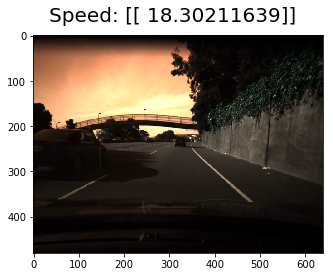

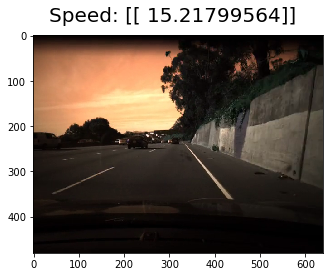

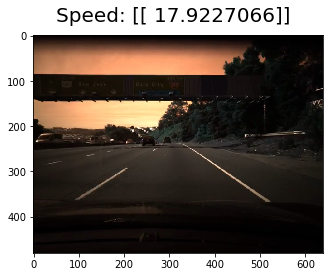

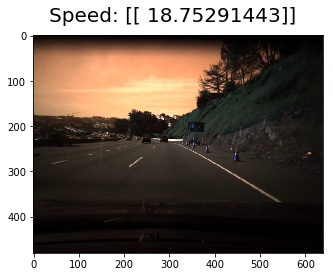

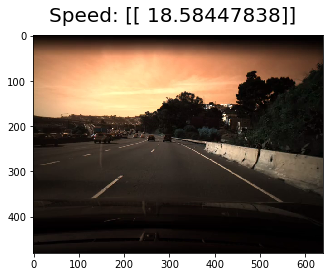

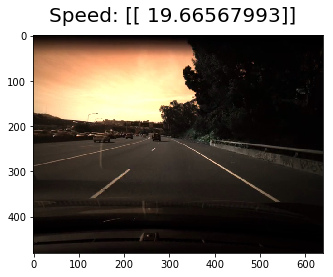

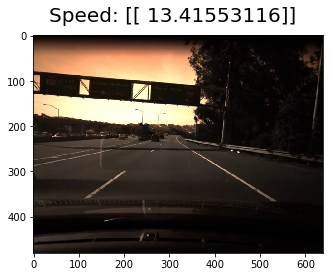

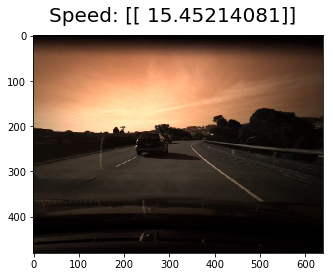

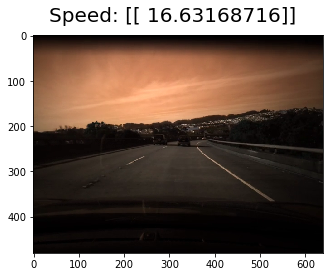

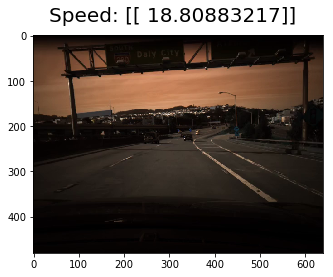

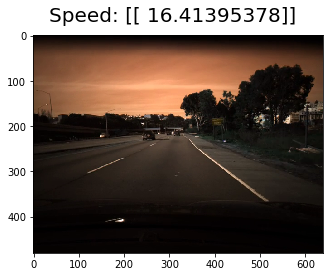

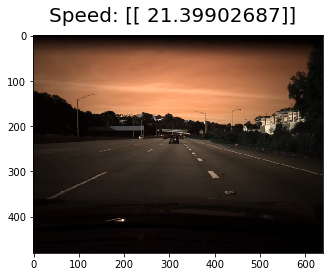

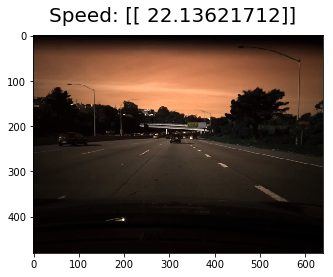

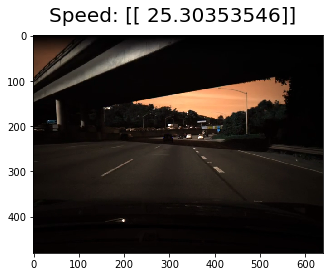

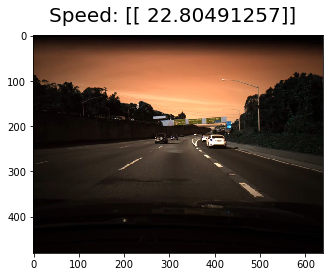

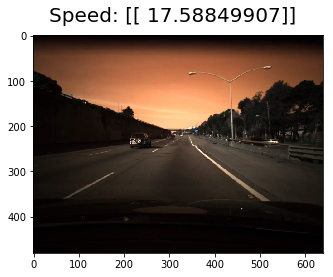

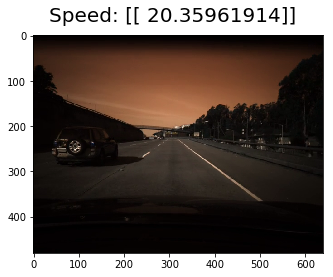

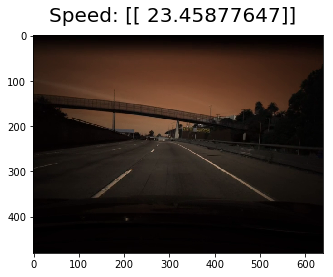

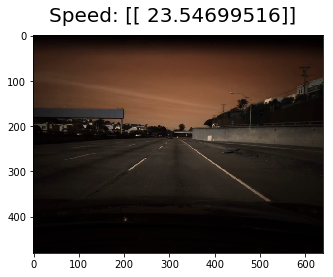

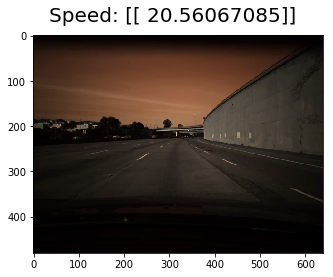

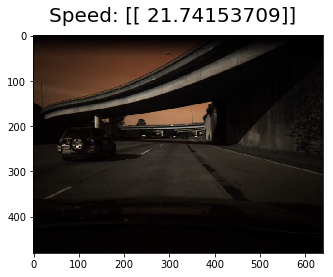

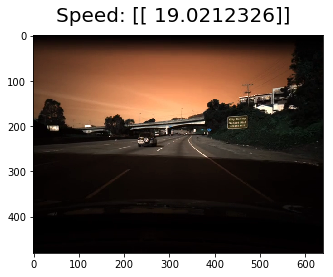

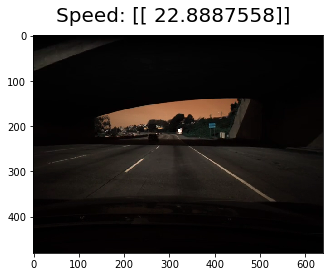

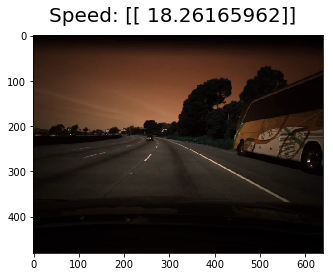

In [71]:
import pylab
import imageio
filename = 'data/test.mp4'
vid = imageio.get_reader(filename,  'ffmpeg')

for i in range(0,5000,100):
    try:
        f1 = vid.get_data(i)
        f2 = vid.get_data(i+1)
        
    except:
        print("End of Video")
        break
    
    f1 = cv2.cvtColor(f1,cv2.COLOR_BGR2RGB)
    f2 = cv2.cvtColor(f2,cv2.COLOR_BGR2RGB)
    
    
    test_img = cv2.resize(crop(opt_flow(f1,f2),360,0),(160,90))
    test_img[:,:,1] = np.sin(test_img[:,:,1]*2*np.pi/180)
    test_img /= [166.5,1]
    
    
    y = model.predict(test_img[None,:])
    fig = pylab.figure()
    fig.suptitle('Speed: {}'.format(y), fontsize=20)
    plt.imshow(f1)
    plt.show()
        

In [68]:
`

SyntaxError: invalid syntax (<ipython-input-68-a128b681c636>, line 1)